In [1]:
import pandas as pd
import yaml
from utilities.utilities import exposure_new, read_ac_data, gdp_from_cdd_exposure, read_projections, add_historical_gdp_growth, calculate_average_gdp_growth
from utilities.plotting import plot_exposure_map, plot_exposure_contour, plot_gdp_increase_map, plot_gdp_increase_scatter

In [2]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

/Users/aliciawongel/CLab/clab_experiencedT/utilities/plotting.py:16: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not [482.2543956025482, 26    277.047368
dtype: float64, 26    170.107342
dtype: float64, 26    116.646767
dtype: float64, 26    88.390217
dtype: float64]

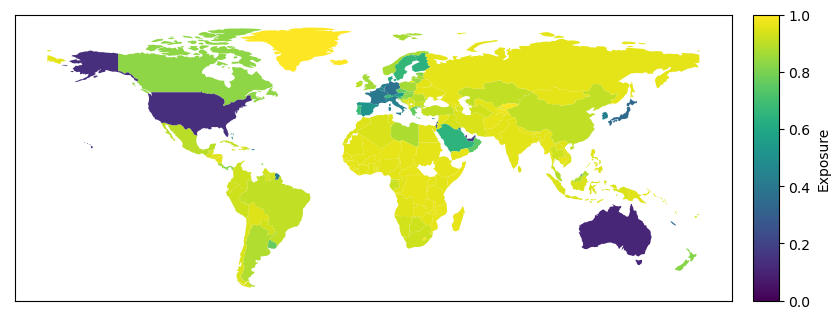

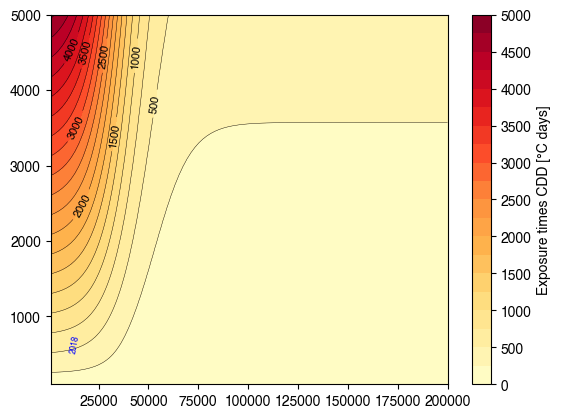

In [3]:
# Read in historical AC, GDP, DD data
ac_data_historical = read_ac_data('data_experiencedT/AC_data.csv')

# Plot exposure map (supporting material)
ac_data_map_geo = plot_exposure_map(ac_data_historical)

# Add predictions for DD_mean and GDP for the countries in ac_data
dd_projections = read_projections(config, 'cdd', ac_data_historical)
gdp_projections = read_projections(config, 'gdp', ac_data_historical)

# Merge the two dataframes
merged_projections = pd.merge(dd_projections, gdp_projections, on='ISO3')

# Combine historical and projections into one dataframe
ac_data = pd.merge(ac_data_historical, merged_projections, on='ISO3')
ac_data = ac_data.reset_index(drop=True)

# Add column for historical exposure times CDD
ac_data['exposure_times_cdd'] = exposure_new(ac_data['GDP'], ac_data['DD_mean'])*ac_data['DD_mean']

# Plot exposure contour
plot_exposure_contour(config, exposure_new, ac_data, x_y_ranges=[[100, 5000, 100],[1000, 200000, 100]], 
                      name_tag='exposure_contour')

# Plot contour for one country with x and y percent increase in CDD and GDP
plot_exposure_contour(config, exposure_new, ac_data, x_y_ranges=[[0, 50, 100],[0, 5, 100]],
                    country='NGA', name_tag='exposure_contour_country_NGA')

# Add historical GDP growth
ac_data = add_historical_gdp_growth(ac_data, config)

# Reset index to ISO3
ac_data_map_geo.set_index('ISO3', inplace=True)
ac_data.set_index('ISO3', inplace=True)

for scenario in [config['base_future_scenario']]:

    # Calculate GDP needed to keep exposure times CDD constant
    gdp_const = gdp_from_cdd_exposure(ac_data['exposure_times_cdd'], ac_data['CDD_{0}_{1}'.format(scenario, config['future_years'][-1])])
    ac_data['gdp_const_{}'.format(scenario)] = calculate_average_gdp_growth(gdp_const, ac_data['GDP'], config['future_years'][-1] - config['ref_year'])
    
    plot_gdp_increase_map(config, ac_data, ac_data_map_geo, scenario)
    plot_gdp_increase_scatter(ac_data, scenario)
